In [5]:
import backtrader as bt
import pandas as pd
from numpy import *
%matplotlib inline
import backtrader.analyzers as btanalyzers

def feed_my_data(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = ['open_time','open','high','low','close','volume','close_time']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df.set_index('open_time')
    df = df.resample('5min').last()
    
    feeds = bt.feeds.PandasDirectData(
    name=csv_path.split('U')[0], # 多股回测时用户区分数据对象
    timeframe = bt.TimeFrame.Minutes,
    dataname=df,
#     datetime=0,  # 日期行所在列
    dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
    tmformat=('%H:%M:%S'), # 时间格式
    open=1,  # 开盘价所在列
    high=2,  # 最高价所在列
    low=3,  # 最低价所在列
    close=4,  # 收盘价价所在列
    volume=5,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
    )
    cerebro.adddata(feeds)

In [6]:
# 创建一个策略
pnl = pd.DataFrame()
value_lis = []
date_lis = []

sharpe_lis = []
class DualThrust(bt.Strategy):
    # 需要调优的参数
    params = (
        ('N', 7),
        ('K',0.3),
        ('stop_loss',2),
        ('stop_gain',100)
        )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.close_p = dict()
        self.high = dict()
        self.low = dict()
        self.open = dict()
        self.open_ = dict()
        self.high_lis, self.low_lis, self.close_p_lis, self.single_day_high_lis, self.single_day_low_lis = {}, {}, {}, {}, {}
        self.BuyLine, self.SellLine = {}, {}
        self.size, self.value_perday = {}, {}
        
        for data in self.datas:
            self.close_p[data._name] = data.close
            self.high[data._name] = data.high
            self.low[data._name] = data.low
            self.open[data._name] = data.open
            
            self.high_lis[data._name] = []
            self.low_lis[data._name] = []
            self.close_p_lis[data._name] = []
            self.single_day_high_lis[data._name] = []
            self.single_day_low_lis[data._name] = []
            
            self.BuyLine[data._name] = None
            self.SellLine[data._name] = None
            
            self.value_perday[data._name] = []
            
        self.N = self.params.N
        self.K1 = self.params.K
        self.K2 = self.params.K
        self.stop_loss = self.params.stop_loss/100
        self.stop_gain = self.params.stop_gain/100        
        
        self.day_counter = 0
        self.start_strategy = False
        
    
    def prenext(self):
        pass
    
    def next(self):
        date = self.datas[0].datetime.datetime(0)
        day = str(date).split(' ')[0]
        time = str(date).split(' ')[1]
        for data in self.datas:
            self.size[data._name] = self.getposition(data = data).size
            self.single_day_high_lis[data._name].append(data.high[0])
            self.single_day_low_lis[data._name].append(data.low[0])
        
        if time == '00:00:00':
            self.day_counter += 1
            
            for data in self.datas:
                self.open_[data._name] = data.open[0]
                self.close_p_lis[data._name].append(data.close[0])
                self.high_lis[data._name].append(max(self.single_day_high_lis[data._name]))
                self.low_lis[data._name].append(min(self.single_day_low_lis[data._name]))
                self.value_perday[data._name].append(self.broker.getvalue())
                self.single_day_high_lis[data._name] = []
                self.single_day_low_lis[data._name] = []
            
            if self.day_counter == self.N:
                # 计算各个指标
                for data in self.datas:
                    HH = max(self.high_lis[data._name])
                    LC = min(self.close_p_lis[data._name])
                    HC = max(self.close_p_lis[data._name])
                    LL = min(self.low_lis[data._name])
#                     print(HH,LC)
#                     print(HC,LL)
#                     self.log(HH,LC)
#                     self.log(HC,LL)
                    Range = max(HH-LC,HC-LL)
                

                    self.BuyLine[data._name] = self.open_[data._name] + self.K1 * Range
                    self.SellLine[data._name] = self.open_[data._name] - self.K2 * Range
                    # 去除第一个保持长度为N
                    self.high_lis[data._name].remove(self.high_lis[data._name][0])
                    self.low_lis[data._name].remove(self.low_lis[data._name][0])
                    self.close_p_lis[data._name].remove(self.close_p_lis[data._name][0])
                    self.start_strategy = True
                    self.day_counter -= 1
                    self.close(data=data)
                    self.log(f'{data._name}收盘平仓')


        if self.start_strategy:
            for data in self.datas:
                cross_upper = data.high[0] - self.BuyLine[data._name] > 0
                cross_lower = data.low[0] - self.SellLine[data._name] < 0
            
                if self.size[data._name] != 0:
                    unrealized_pnl = data.close[0]/self.getposition(data).price - 1    
                    if (self.size[data._name] > 0 and unrealized_pnl <= -self.stop_loss) or (self.size[data._name] < 0 and unrealized_pnl >= self.stop_loss):
                        self.close(data=data)
                        self.log(f'{data._name}止损平仓')
                        unrealized_pnl=0
                    
                if cross_upper and self.size[data._name] <= 0:
                    self.close(data=data)
                    self.log(self.getposition(data = data).size)
                    self.buy(data=data)
                    self.log(f'{data._name}买入开多')
                    self.log(self.getposition(data = data).size)

                if cross_lower and self.size[data._name] >= 0:
                    self.close(data=data)
                    self.log(self.getposition(data = data).size)
                    self.sell(data=data)
                    self.log(f'{data._name}卖出做空')
                    self.log(self.getposition(data = data).size)
        
        # 获取当天value
        value = self.broker.getvalue()
        date_lis.append(date)
        value_lis.append(value)
        
#     def stop(self):
#         return_perday = [self.value_perday[x]/self.value_perday[x-1] - 1 for x in range(len(self.value_perday)) if x != 0]
#         mean_v = mean(return_perday)
#         std_v = std(return_perday)
#         sharpe = (mean_v - 0.04/365)/std_v * 365 ** 0.5
#         sharpe_lis.append(sharpe)

In [7]:
value_lis = []
date_lis = []

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
feed_my_data('BTCUSDTtwo.csv')
feed_my_data('ETHUSDTtwo.csv')
feed_my_data('BNBUSDTtwo.csv')
feed_my_data('DOGEUSDTtwo.csv')
cerebro.addstrategy(DualThrust)
cerebro.broker.setcommission(commission=0.0004)
commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addsizer(bt.sizers.AllInSizer,percents=20)

thestrats = cerebro.run()
thestrat = thestrats[0]
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00000
2020-11-07, BTC收盘平仓
2020-11-07, ETH收盘平仓
2020-11-07, BNB收盘平仓
2020-11-07, DOGE收盘平仓
2020-11-07, 0
2020-11-07, DOGE卖出做空
2020-11-07, 0
2020-11-07, 0
2020-11-07, BNB卖出做空
2020-11-07, 0
2020-11-07, 0
2020-11-07, ETH卖出做空
2020-11-07, 0
2020-11-07, 0
2020-11-07, BTC卖出做空
2020-11-07, 0
2020-11-08, ETH止损平仓
2020-11-08, BTC止损平仓
2020-11-08, DOGE止损平仓
2020-11-08, BNB止损平仓
2020-11-08, 0.0
2020-11-08, BNB卖出做空
2020-11-08, 0.0
2020-11-09, BNB止损平仓
2020-11-09, 0.0
2020-11-09, BNB卖出做空
2020-11-09, 0.0
2020-11-09, BNB止损平仓
2020-11-09, 0.0
2020-11-09, BNB卖出做空
2020-11-09, 0.0
2020-11-09, 0.0
2020-11-09, DOGE卖出做空
2020-11-09, 0.0
2020-11-10, DOGE止损平仓
2020-11-10, 0.0
2020-11-10, DOGE买入开多
2020-11-10, 0.0
2020-11-10, DOGE止损平仓
2020-11-11, BTC收盘平仓
2020-11-11, ETH收盘平仓
2020-11-11, BNB收盘平仓
2020-11-11, DOGE收盘平仓
2020-11-12, 0.0
2020-11-12, BTC买入开多
2020-11-12, 0.0
2020-11-12, BTC止损平仓
2020-11-12, 0.0
2020-11-12, BTC买入开多
2020-11-12, 0.0
2020-11-13, 0.0
2020-11-13, ETH买入开多
2020-11-13, 0.0
2020-1

2021-01-17, 0.0
2021-01-17, BNB买入开多
2021-01-17, 0.0
2021-01-18, BTC收盘平仓
2021-01-18, ETH收盘平仓
2021-01-18, BNB收盘平仓
2021-01-18, DOGE收盘平仓
2021-01-21, 0.0
2021-01-21, BNB卖出做空
2021-01-21, 0.0
2021-01-21, BNB止损平仓
2021-01-21, 0.0
2021-01-21, BNB卖出做空
2021-01-21, 0.0
2021-01-21, BNB止损平仓
2021-01-21, 0.0
2021-01-21, BNB卖出做空
2021-01-21, 0.0
2021-01-22, BTC收盘平仓
2021-01-22, ETH收盘平仓
2021-01-22, BNB收盘平仓
2021-01-22, DOGE收盘平仓
2021-01-24, 0.0
2021-01-24, ETH买入开多
2021-01-24, 0.0
2021-01-25, ETH止损平仓
2021-01-26, BTC收盘平仓
2021-01-26, ETH收盘平仓
2021-01-26, BNB收盘平仓
2021-01-26, DOGE收盘平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DOGE止损平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DOGE止损平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DOGE止损平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DOGE止损平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DOGE止损平仓
2021-01-28, 0.0
2021-01-28, DOGE买入开多
2021-01-28, 0.0
2021-01-28, DO

2021-06-11, BTC收盘平仓
2021-06-11, ETH收盘平仓
2021-06-11, BNB收盘平仓
2021-06-11, DOGE收盘平仓
2021-06-15, BTC收盘平仓
2021-06-15, ETH收盘平仓
2021-06-15, BNB收盘平仓
2021-06-15, DOGE收盘平仓
2021-06-19, BTC收盘平仓
2021-06-19, ETH收盘平仓
2021-06-19, BNB收盘平仓
2021-06-19, DOGE收盘平仓
2021-06-23, BTC收盘平仓
2021-06-23, ETH收盘平仓
2021-06-23, BNB收盘平仓
2021-06-23, DOGE收盘平仓
2021-06-27, BTC收盘平仓
2021-06-27, ETH收盘平仓
2021-06-27, BNB收盘平仓
2021-06-27, DOGE收盘平仓
2021-07-01, BTC收盘平仓
2021-07-01, ETH收盘平仓
2021-07-01, BNB收盘平仓
2021-07-01, DOGE收盘平仓
2021-07-05, BTC收盘平仓
2021-07-05, ETH收盘平仓
2021-07-05, BNB收盘平仓
2021-07-05, DOGE收盘平仓
2021-07-09, BTC收盘平仓
2021-07-09, ETH收盘平仓
2021-07-09, BNB收盘平仓
2021-07-09, DOGE收盘平仓
2021-07-13, BTC收盘平仓
2021-07-13, ETH收盘平仓
2021-07-13, BNB收盘平仓
2021-07-13, DOGE收盘平仓
2021-07-17, BTC收盘平仓
2021-07-17, ETH收盘平仓
2021-07-17, BNB收盘平仓
2021-07-17, DOGE收盘平仓
2021-07-21, BTC收盘平仓
2021-07-21, ETH收盘平仓
2021-07-21, BNB收盘平仓
2021-07-21, DOGE收盘平仓
2021-07-25, BTC收盘平仓
2021-07-25, ETH收盘平仓
2021-07-25, BNB收盘平仓
2021-07-25, DOGE收盘平仓
2021-07-29, BTC收盘平仓
2021-07-

In [ ]:
sharpe_lis

In [ ]:
cerebro.plot()

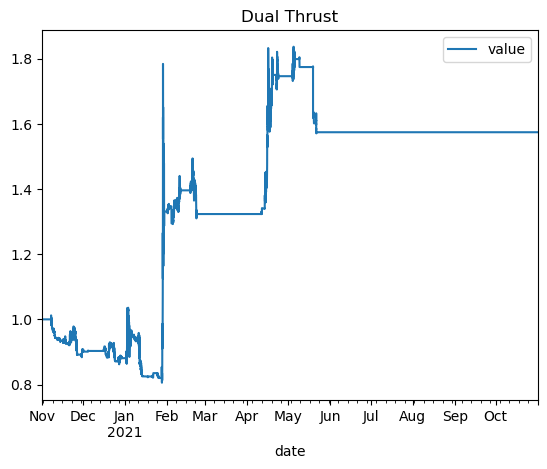

In [4]:
import numpy as np
pnl = pd.DataFrame()
pnl['date'] = date_lis
# pnl['BTC'] = np.array(df['close']/df['close'][0])
pnl['value'] = np.array(value_lis)/value_lis[0]

pnl = pnl.set_index('date')
pnl.plot(title='Dual Thrust')

In [ ]:
pnl['2022-09-21 12:00:00':'2022-09-21 21:30:00'].plot()

# 参数调优

In [ ]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
cerebro.adddata(feeds)
cerebro.broker.setcommission(commission=0.0004)

cerebro.optstrategy(
    strategy=DualThrust,
    N=[3, 7],
    K = [0.5],
    stop_loss = [0.2]
)

commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns",timeframe=bt.TimeFrame.Minutes)
result = cerebro.run(maxcpus=1)
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

In [ ]:
par_list = [[x[0].params.N,
             x[0].params.K,
            x[0].analyzers.returns.get_analysis()['rtot'], 
            x[0].analyzers.drawdown.get_analysis()['max']['drawdown']/100,
                ] for x in result]

par_df = pd.DataFrame(par_list, columns = ['N', 'K', 'return', 'max_drawdown'])
par_df['sharpe'] = sharpe_lis
par_df